# Introduction

In this project we have to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted.

Evaluation :
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.



In [1]:
# Importing all required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# For ignoring the warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import gc
gc.enable()

In [2]:
# Fetching the data to pandas dataframes
train = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')
sub = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv')

## Let's explore the training data first

In [3]:
# Checking training data
train.shape

(200000, 202)

The training data has 202 columns and 200000 rows that will provide us a good amount of data for training our machine learning models

In [4]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


As we can see the data is anonymized by the company and only target and Id are provided without anonymizing, we would need to explore the data and formulate certain hypothesis to de-anonymize the data and infer some valuable insights from the data that will help us predict the target value for test data

In [5]:
# Checking the datatypes of columns
train.dtypes

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 202, dtype: object

In [6]:
train.dtypes.value_counts()

float64    200
int64        1
object       1
dtype: int64

All the anonymized columns i.e var_0 to var_199 have float datatype, we will have to check the values of all the columns if they are actually a numeric type values or are encoded to values from a categorical type variable.<br>
We will then decode the values back to categorical features and that might improve the accuracy of our predictions

# Exploratory data analysis

## Checking for missing values in the data

In [7]:
train.isna().sum().sort_values(ascending = False).head()

var_199    0
var_61     0
var_71     0
var_70     0
var_69     0
dtype: int64

As this is a banking related data, as expected there are no null values present in the data, that means the data is properly recorded by the bank without any failure

## Let's explore the columns now

In [8]:
# Checking if every row has unique id
len(train['ID_code'].unique())

200000

In [9]:
# Target column
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

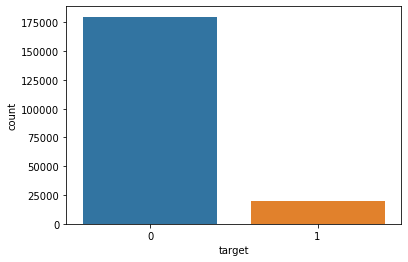

In [10]:
ax = sns.countplot(x="target",data=train)

The target variable is highly imbalanced as value 0 has a much higher count then the value 1.<br>
we will need to consider this while doing cross validation of a model that balanced sample is taken for prediction and for cross validation

## Checking for duplicate columns

Firstly we will encode each and every column using tqdm function which works as a pipeline operator for handing big amount of data.

Fun Fact : **tqdm means "progress" in Arabic (taqadum, تقدّم) and is an abbreviation for "I love you so much" in Spanish (te quiero demasiado).**

In [11]:
import tqdm
train_enc = pd.DataFrame(index = train.index)
for col in tqdm.tqdm_notebook(train.columns):
    train_enc[col] = train[col].factorize()[0]

There are no duplicate columns present in the data

# Feature Skewness

In [12]:
feature_names = train.columns[2:]
feature_names


Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

In [13]:
# Find skewed numerical features
skew_features = train[feature_names].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 0 numerical features with Skew > 0.5 :


var_168    0.267412
var_2      0.260312
var_179    0.242889
var_0      0.235637
var_163    0.234778
var_191    0.209277
var_181    0.205354
var_29     0.200363
var_60     0.194541
var_62     0.193415
dtype: float64

As there are not highly skewed features, we do not need to apply any transformation on the data

# Outliers

As the data is huge, we will first calculate the z-score of the training data and then we will further explore if the value found is to be treated as an outlier or not

In [14]:
# Dropping ID and target columns
z_score_calc = train.drop(columns=['ID_code', 'target'])
# Calculating z score
z = np.abs(stats.zscore(z_score_calc))
# print(z)
threshold = 3
print(np.where(z > 4))

(array([  5223,  15110,  27150,  28440,  36684,  39763,  50289,  54707,
        66186,  78143,  92221,  94371,  96076, 101997, 103190, 119725,
       125921, 127324, 138420, 142599, 145204, 145707, 158355, 164048,
       171009, 180741, 198357]), array([ 28,  31, 167,  58, 120, 167, 149, 106,  38, 124, 105,  44, 171,
       146, 149,  38,  31,  67, 186,  67, 192,  17,  28, 106, 124, 149,
        52]))


The first array gives the row numbers and the 2nd array gives the respective columns of the outliers

In [15]:
treated_data = train[(z < 4).all(axis=1)]

In [16]:
print("before treating outliers : {}".format(train.shape))
print("after treating outliers : {}".format(treated_data.shape))

before treating outliers : (200000, 202)
after treating outliers : (199973, 202)


### We have removed **27** rows having outliers

We will try fitting our model on treated and non treated data to see which one performs better and then we can try changing the threshold value for finding outliers

# Feature Selection

In [17]:
treated_data.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [18]:
# Creating the variables for model fitting
X = treated_data.drop(columns=['ID_code', 'target'])
y = treated_data['target']

# Test variable
test = test.drop(columns=['ID_code'])

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3, random_state=0)

In [20]:
## Import the random forest model.
from sklearn.ensemble import RandomForestClassifier
## This line instantiates the model. 
rf = RandomForestClassifier() 
## Fit the model on your training data.
rf.fit(X_train, y_train) 
## And score it on your testing data.
rf.score(X_test, y_test)

0.8989698626483531

In [21]:
prediction_rf = rf.predict(test)

In [22]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [23]:
submission=pd.DataFrame({"ID_code":sub['ID_code'],
                         "target":prediction_rf})
submission.to_csv('submission_rf.csv',index=False)

In [24]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [25]:
feature_importances

,importance
var_81,0.011980
var_12,0.009721
var_139,0.009674
var_110,0.008872
var_53,0.008674
...,...
var_47,0.003748
var_10,0.003740
var_103,0.003732
var_14,0.003695


In [26]:
feature_importances.median()

importance    0.004603
dtype: float64

In [27]:
feature_importances.tail(15)

,importance
var_160,0.003850
var_61,0.003837
var_65,0.003830
var_96,0.003828
var_185,0.003818
var_30,0.003796
var_74,0.003794
var_17,0.003794
var_27,0.003776
var_7,0.003764


Removing the features that have importance less than 0.0038


In [28]:
X_train.drop( ['var_38','var_158','var_73','var_14','var_10','var_84','var_61','var_103','var_185'],axis = 1,inplace = True )
X_test.drop( ['var_38','var_158','var_73','var_14','var_10','var_84','var_61','var_103','var_185'],axis = 1 , inplace = True)
X_train.head()


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
32178,7.6999,3.7840,9.8171,5.0791,12.8524,12.7216,5.0437,18.3089,7.1343,7.4869,...,2.4898,6.8529,3.1746,10.3572,16.1768,1.1554,9.1196,7.8276,16.8092,-8.9624
178629,16.4311,1.9357,10.4754,6.5338,12.4222,11.2145,4.7007,17.2400,2.3365,7.6795,...,3.0262,11.8332,3.5578,8.8971,18.0380,0.2402,10.0714,8.2904,15.0036,-8.4034
197995,9.2492,2.4173,7.2113,7.0864,12.2992,0.6188,6.1643,13.9896,6.4193,7.7841,...,10.4666,7.3260,2.9770,-1.1117,18.0961,1.7752,2.1947,10.0754,15.7944,-5.5711
94984,11.5929,-1.1233,11.4183,5.9913,10.7316,9.9136,6.8948,21.5341,0.1937,6.1479,...,3.4316,6.8095,1.2794,2.6125,15.9085,-0.9734,9.4480,9.7438,15.4993,3.7759
142786,7.9363,-4.6226,12.5803,7.7257,12.4638,-2.2030,5.9775,12.3446,2.6868,9.0083,...,-0.9470,10.6522,2.3779,2.5282,21.2079,-3.4420,-2.5667,9.9004,13.6585,6.9903


In [29]:
rf.fit(X_train, y_train) 
## And score it on your testing data.
rf.score(X_test, y_test)

0.8989698626483531

In [30]:
feature_selected_test = test.drop( ['var_38','var_158','var_73','var_14','var_10','var_84','var_61','var_103','var_185'],axis = 1)
feature_selected_test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [31]:
prediction_rf = rf.predict(feature_selected_test)

In [32]:
submission=pd.DataFrame({"ID_code":sub['ID_code'],
                         "target":prediction_rf})
submission.to_csv('submission_rf2.csv',index=False)